# imports


In [3]:
!pip install transformers timm flash_attn einops

  Using cached flash_attn-2.7.2.post1.tar.gz (3.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash_attn


In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoProcessor, set_seed, AutoModelWithLMHead
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import tensorflow as tf
import numpy as np
import albumentations as album
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import classification_report
import gc

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# florence-2-large


In [6]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=True,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
id = 772
img_path = "../toy_dataset/toy_dataset/" + str(id) + ".jpg"

The image is a painting of a scene from a medieval manuscript. It shows a group of people gathered around a table in a room with a stone wall and an archway. On the left side of the image, there is a woman sitting on a bench, wearing a red robe and a white headscarf. She is holding a book in her hands and appears to be reading from it. Next to her, there are two men, one wearing a blue robe and the other wearing a white robe, who are standing in front of the table. The man in the blue robe is handing something to the woman in the white robe. The woman is wearing a long white robe with a blue sash and a red hat. The two men in the red robes are also wearing blue robes and hats. They are both holding books and appear to be engaged in a conversation.

The background of the painting is a blue sky with white clouds. The floor is made of stone tiles and there are several potted plants scattered around the room. The overall mood of the scene is peaceful and serene.


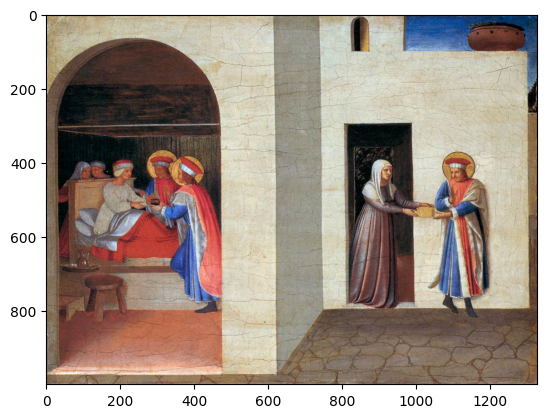

In [11]:
task_prompt = "<MORE_DETAILED_CAPTION>"
img = Image.open(img_path).convert("RGB")
answer = run_example(task_prompt=task_prompt, image=img)

print(answer[task_prompt])
plt.imshow(img)

In [12]:
id = 23330
img_path = "/content/drive/MyDrive/toy_dataset/toy_dataset/" + str(id) + ".jpg"

The image is a painting of a canal scene with a bridge in the background. The bridge appears to be old and weathered, with arches and pillars supporting it. The water is calm and there are several boats on the surface of the water. On the left side of the image, there is a large boat with a red cloth draped over it, and on the right side, there are a few people working on the boats. There are also several barrels and other items scattered around the scene.

In the center of the painting, a group of men are gathered around a wooden table, working on a boat. Some of the men are bending down to pick up something from the ground, while others are standing on the edge of the table. There is also a man in a red robe and a woman in a white dress, both of whom appear to be working on something. The man in the red robe is holding a basket of goods, and the woman in the white dress is standing next to him, looking at the items on the table with a concerned expression on her face. The painting is

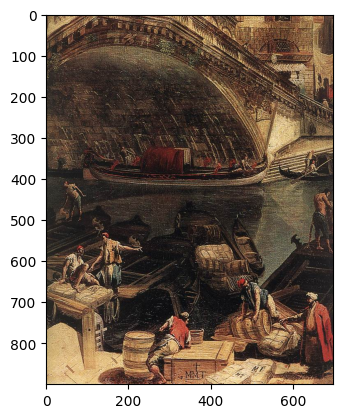

In [13]:
task_prompt = "<MORE_DETAILED_CAPTION>"
img = Image.open(img_path).convert("RGB")
answer = run_example(task_prompt=task_prompt, image=img)

print(answer[task_prompt])
plt.imshow(img)